In [1]:
import pandas as pd

Наши новости

In [2]:
news = pd.read_csv("materials.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [4]:
pip install -U gensim

Note: you may need to restart the kernel to use updated packages.


In [5]:
#from gensim.test.utils import common_texts

from gensim.corpora.dictionary import Dictionary

In [6]:
!pip install razdel

In [7]:
pip install pymorphy2

Note: you may need to restart the kernel to use updated packages.


In [8]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\denva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [11]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [12]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [13]:
%%time

news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-12-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 24.7 s


In [14]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 3min 2s


In [15]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [16]:
common_dictionary[40]

'оао'

In [17]:
common_dictionary.id2token

{0: 'nn',
 1: 'александр',
 2: 'алексей',
 3: 'андрей',
 4: 'армеец',
 5: 'банк',
 6: 'баскетбол',
 7: 'близкий',
 8: 'блок',
 9: 'борьба',
 10: 'ватутин',
 11: 'взаимодействие',
 12: 'власть',
 13: 'войти',
 14: 'вячеслав',
 15: 'генералполковник',
 16: 'генеральный',
 17: 'георгий',
 18: 'гмк',
 19: 'директор',
 20: 'европа',
 21: 'единогласно',
 22: 'заместитель',
 23: 'заседание',
 24: 'защита',
 25: 'иванов',
 26: 'избрать',
 27: 'исакович',
 28: 'клиентский',
 29: 'клуб',
 30: 'конституционный',
 31: 'корпоративный',
 32: 'леонид',
 33: 'лопат',
 34: 'министр',
 35: 'мир',
 36: 'начальник',
 37: 'никель',
 38: 'новак',
 39: 'норильский',
 40: 'оао',
 41: 'обсуждение',
 42: 'округ',
 43: 'ольга',
 44: 'ооо',
 45: 'орган',
 46: 'основной',
 47: 'пбк',
 48: 'первый',
 49: 'перспектива',
 50: 'планирование',
 51: 'плешаков',
 52: 'политика',
 53: 'полномочный',
 54: 'полтавец',
 55: 'полтавченко',
 56: 'правительство',
 57: 'правление',
 58: 'председатель',
 59: 'представитель',
 60:

In [18]:
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

In [19]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [20]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(10, 0.1685897),
 (13, 0.2716473),
 (22, 0.15221785),
 (23, 0.19195779),
 (24, 0.1977603)]

### Количество тем

In [124]:
x=lda.show_topics(num_topics=10, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_10: флот вина экипаж кольцо медик горизонт вода
topic_2: который год nn первый это день время
topic_24: журнал смерть лауреат австралия команда тур франция
topic_8: определение золото су зуб таможенный визовый золотой
topic_4: год который это исследование стать человек рынок
topic_3: год рубль млрд млн цена стоимость сумма
topic_16: российский год россия президент наука путин это
topic_15: год который это суд решение дело россия
topic_23: ракета запуск сша министерство американский космос продолжительность
topic_0: это который научный мочь погибнуть компания свой


In [125]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [126]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(2)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.104396,0.0,0.0,0.0,0.0,0.000000,0.0354,0.0,0.068351
1,4896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.085457,0.0000,0.0,0.275556


### Следующий шаг - векторные представления пользователей

In [127]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [128]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [129]:
doc_dict[293622]

array([0.        , 0.        , 0.31547609, 0.        , 0.        ,
       0.10266737, 0.        , 0.        , 0.02225547, 0.09172451,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.09222982, 0.01726682, 0.02626442, 0.        ,
       0.08933987, 0.23305991, 0.        , 0.        , 0.        ])

In [130]:
### MEAN

In [131]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
#    user_vector = np.median(user_vector, 0)
    user_vector = np.mean(user_vector, 0)
#     user_vector = np.max(user_vector, 0)
    return user_vector

In [132]:
### MEDIAN

In [133]:
user_articles_list2 = users['articles'].iloc[33]

def get_user_embedding2(user_articles_list2):
    user_articles_list2 = eval(user_articles_list2)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list2])
    user_vector = np.median(user_vector, 0)
#     user_vector = np.mean(user_vector, 0)
#     user_vector = np.max(user_vector, 0)
    return user_vector

In [134]:
### MAX

In [135]:
user_articles_list3 = users['articles'].iloc[33]

def get_user_embedding3(user_articles_list3):
    user_articles_list3 = eval(user_articles_list3)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list3])
#    user_vector = np.median(user_vector, 0)
#     user_vector = np.mean(user_vector, 0)
    user_vector = np.max(user_vector, 0)
    return user_vector

In [136]:
get_user_embedding(user_articles_list)

array([0.06397329, 0.00653517, 0.03554119, 0.        , 0.01820265,
       0.0150283 , 0.        , 0.09044434, 0.        , 0.08932798,
       0.00227309, 0.01422233, 0.        , 0.18519509, 0.01098612,
       0.13470793, 0.14479311, 0.        , 0.05303798, 0.        ,
       0.00502819, 0.08864414, 0.01231894, 0.01102926, 0.00671428])

In [137]:
get_user_embedding2(user_articles_list2)

array([0.02055871, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.05182675, 0.        , 0.0705134 ,
       0.        , 0.        , 0.        , 0.20861387, 0.        ,
       0.1005921 , 0.07649539, 0.        , 0.0057086 , 0.        ,
       0.        , 0.01538885, 0.        , 0.        , 0.        ])

In [138]:
get_user_embedding3(user_articles_list3)

array([0.20229959, 0.02457722, 0.15755497, 0.        , 0.10921587,
       0.04551154, 0.        , 0.30882126, 0.        , 0.23022076,
       0.01363856, 0.08533399, 0.        , 0.39438391, 0.06591674,
       0.33518934, 0.51219553, 0.        , 0.17488091, 0.        ,
       0.03016913, 0.31192052, 0.04262285, 0.06617556, 0.04028568])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [139]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.017873,0.047210,0.084022,0.036964,0.072282,0.054893,0.0,0.015881,0.003709,...,0.133852,0.139006,0.012765,0.014104,0.015979,0.014890,0.057451,0.025570,0.005092,0.002612
1,u108690,0.134294,0.002510,0.056149,0.026870,0.034971,0.061759,0.0,0.014692,0.000000,...,0.121711,0.087258,0.000000,0.026482,0.013945,0.006915,0.038410,0.019780,0.003128,0.002142
2,u108339,0.149646,0.007292,0.041887,0.026045,0.100037,0.006445,0.0,0.023102,0.000000,...,0.174941,0.020459,0.000000,0.029925,0.002118,0.000000,0.076573,0.044773,0.000000,0.000000


In [140]:
user_embeddings2 = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding2(x), 1)])
user_embeddings2.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings2['uid'] = users['uid'].values
user_embeddings2 = user_embeddings2[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings2.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.015355,0.027952,0.031478,0.000000,0.00000,0.0,0.000000,0.0,...,0.062990,0.046115,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
1,u108690,0.132273,0.000000,0.044428,0.000000,0.005328,0.02903,0.0,0.007381,0.0,...,0.062205,0.054853,0.0,0.019745,0.0,0.0,0.037989,0.014513,0.0,0.0
2,u108339,0.151989,0.000000,0.016190,0.007449,0.032874,0.00000,0.0,0.006861,0.0,...,0.197011,0.018935,0.0,0.006229,0.0,0.0,0.083007,0.006265,0.0,0.0


In [141]:
user_embeddings3 = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding3(x), 1)])
user_embeddings3.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings3['uid'] = users['uid'].values
user_embeddings3 = user_embeddings3[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings3.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.064475,0.141017,0.315476,0.090360,0.360049,0.226691,0.0,0.095286,0.022255,...,0.482382,0.457686,0.059324,0.05836,0.095873,0.089340,0.233060,0.114195,0.030552,0.015674
1,u108690,0.248441,0.015058,0.164707,0.108113,0.160294,0.231461,0.0,0.042101,0.000000,...,0.282770,0.318914,0.000000,0.06556,0.073519,0.041491,0.094813,0.048528,0.018766,0.012850
2,u108339,0.256169,0.043749,0.172715,0.117087,0.274233,0.023391,0.0,0.107030,0.000000,...,0.379209,0.046594,0.000000,0.14468,0.012708,0.000000,0.129524,0.163153,0.000000,0.000000


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [142]:
target = pd.read_csv("users_churn.csv")


In [143]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.017873,0.047210,0.084022,0.036964,0.072282,0.054893,0.0,0.015881,0.003709,...,0.139006,0.012765,0.014104,0.015979,0.014890,0.057451,0.025570,0.005092,0.002612,0
1,u108690,0.134294,0.002510,0.056149,0.026870,0.034971,0.061759,0.0,0.014692,0.000000,...,0.087258,0.000000,0.026482,0.013945,0.006915,0.038410,0.019780,0.003128,0.002142,1
2,u108339,0.149646,0.007292,0.041887,0.026045,0.100037,0.006445,0.0,0.023102,0.000000,...,0.020459,0.000000,0.029925,0.002118,0.000000,0.076573,0.044773,0.000000,0.000000,1


In [144]:
X2 = pd.merge(user_embeddings2, target, 'left')
X2.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.015355,0.027952,0.031478,0.000000,0.00000,0.0,0.000000,0.0,...,0.046115,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0
1,u108690,0.132273,0.000000,0.044428,0.000000,0.005328,0.02903,0.0,0.007381,0.0,...,0.054853,0.0,0.019745,0.0,0.0,0.037989,0.014513,0.0,0.0,1
2,u108339,0.151989,0.000000,0.016190,0.007449,0.032874,0.00000,0.0,0.006861,0.0,...,0.018935,0.0,0.006229,0.0,0.0,0.083007,0.006265,0.0,0.0,1


In [145]:
X3 = pd.merge(user_embeddings3, target, 'left')
X3.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.064475,0.141017,0.315476,0.090360,0.360049,0.226691,0.0,0.095286,0.022255,...,0.457686,0.059324,0.05836,0.095873,0.089340,0.233060,0.114195,0.030552,0.015674,0
1,u108690,0.248441,0.015058,0.164707,0.108113,0.160294,0.231461,0.0,0.042101,0.000000,...,0.318914,0.000000,0.06556,0.073519,0.041491,0.094813,0.048528,0.018766,0.012850,1
2,u108339,0.256169,0.043749,0.172715,0.117087,0.274233,0.023391,0.0,0.107030,0.000000,...,0.046594,0.000000,0.14468,0.012708,0.000000,0.129524,0.163153,0.000000,0.000000,1


In [146]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [147]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [148]:
#разделим данные на train/test
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2[['topic_{}'.format(i) for i in range(25)]], 
                                                    X2['churn'], random_state=0)

In [149]:
#разделим данные на train/test
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3[['topic_{}'.format(i) for i in range(25)]], 
                                                    X3['churn'], random_state=0)

In [150]:
logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression()

In [151]:
logreg2 = LogisticRegression()
#обучим наш пайплайн
logreg2.fit(X_train2, y_train2)

LogisticRegression()

In [152]:
logreg3 = LogisticRegression()
#обучим наш пайплайн
logreg3.fit(X_train3, y_train3)

LogisticRegression()

In [153]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.08423822, 0.03286833, 0.52163381, 0.13980133, 0.04884669,
       0.06216798, 0.12557695, 0.11595069, 0.06165815, 0.08083139])

In [154]:
preds2 = logreg2.predict_proba(X_test2)[:, 1]
preds2[:10]

array([0.07015416, 0.02779807, 0.68654483, 0.23045368, 0.02819799,
       0.07206459, 0.06671224, 0.437478  , 0.15413992, 0.07861032])

In [155]:
preds3 = logreg3.predict_proba(X_test3)[:, 1]
preds2[:10]

array([0.07015416, 0.02779807, 0.68654483, 0.23045368, 0.02819799,
       0.07206459, 0.06671224, 0.437478  , 0.15413992, 0.07861032])

In [156]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [157]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.267472, F-Score=0.696, Precision=0.655, Recall=0.743


In [158]:
### Median

In [159]:
precision2, recall2, thresholds2 = precision_recall_curve(y_test2, preds2)
fscore2 = (2 * precision2 * recall2) / (precision2 + recall2)
# locate the index of the largest f score
ix2 = np.argmax(fscore2)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds2[ix2], 
                                                                        fscore2[ix2],
                                                                        precision2[ix2],
                                                                        recall2[ix2]))

Best Threshold=0.289149, F-Score=0.764, Precision=0.706, Recall=0.833


In [160]:
### MAX

In [161]:
precision3, recall3, thresholds3 = precision_recall_curve(y_test3, preds3)
fscore3 = (2 * precision3 * recall3) / (precision3 + recall3)
# locate the index of the largest f score
ix3 = np.argmax(fscore3)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds3[ix3], 
                                                                        fscore3[ix3],
                                                                        precision3[ix3],
                                                                        recall3[ix3]))

Best Threshold=0.365096, F-Score=0.817, Precision=0.806, Recall=0.829


In [162]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1659   96]
 [  64  181]]


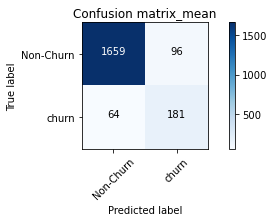

In [163]:

font = {'size' : 10}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(6, 3))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix_mean')
plt.savefig("conf_matrix.png")
plt.show()

Confusion matrix, without normalization
[[1670   85]
 [  42  203]]


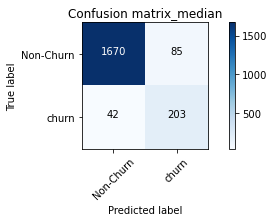

In [164]:
font = {'size' : 10}

plt.rc('font', **font)

cnf_matrix2 = confusion_matrix(y_test2, preds2>thresholds2[ix2])
plt.figure(figsize=(6, 3))
plot_confusion_matrix(cnf_matrix2, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix_median')
plt.savefig("conf_matrix2.png")
plt.show()

Confusion matrix, without normalization
[[1706   49]
 [  43  202]]


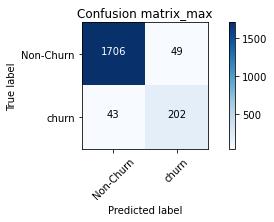

In [165]:
font = {'size' : 10}

plt.rc('font', **font)

cnf_matrix3 = confusion_matrix(y_test3, preds3>thresholds3[ix3])
plt.figure(figsize=(6, 3))
plot_confusion_matrix(cnf_matrix3, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix_max')
plt.savefig("conf_matrix3.png")
plt.show()

In [166]:
####mean

In [167]:
roc_auc_score(y_test, preds)

0.9565928251642537

In [168]:
### median

In [169]:
roc_auc_score(y_test2, preds2)

0.9719541833827549

In [170]:
### max

In [171]:
roc_auc_score(y_test3, preds3)

0.9828617942903658

In [69]:
##Сводая таблица результатов метрик  при num_topics=15

In [70]:
df = pd.DataFrame({'get_user_embedding': ['mean', 'median', 'max'], 'f-score': [fscore[ix], fscore2[ix2], fscore3[ix3]], 'thresholds': [thresholds[ix], thresholds2[ix2], thresholds3[ix3]],'precision': [precision[ix], precision2[ix2], precision3[ix3]], 'recall': [recall[ix], recall2[ix2], recall3[ix3]], 'roc_auc_score' : [roc_auc_score(y_test, preds), roc_auc_score(y_test2, preds2), roc_auc_score(y_test3, preds3)]})
df

,get_user_embedding,f-score,thresholds,precision,recall,roc_auc_score
0,mean,0.696629,0.259662,0.643599,0.759184,0.956623
1,median,0.766038,0.291486,0.712281,0.828571,0.972191
2,max,0.817073,0.367856,0.813765,0.820408,0.982608


In [71]:
##Сводая таблица результатов метрик  при num_topics=25

In [123]:
df = pd.DataFrame({'get_user_embedding': ['mean', 'median', 'max'], 'f-score': [fscore[ix], fscore2[ix2], fscore3[ix3]], 'thresholds': [thresholds[ix], thresholds2[ix2], thresholds3[ix3]],'precision': [precision[ix], precision2[ix2], precision3[ix3]], 'recall': [recall[ix], recall2[ix2], recall3[ix3]], 'roc_auc_score' : [roc_auc_score(y_test, preds), roc_auc_score(y_test2, preds2), roc_auc_score(y_test3, preds3)]})
df

,get_user_embedding,f-score,thresholds,precision,recall,roc_auc_score
0,mean,0.697318,0.266554,0.657040,0.742857,0.956828
1,median,0.768916,0.326602,0.770492,0.767347,0.972824
2,max,0.818737,0.373081,0.817073,0.820408,0.982741


In [172]:
##Сводая таблица результатов метрик  при num_topics=10

In [173]:
df = pd.DataFrame({'get_user_embedding': ['mean', 'median', 'max'], 'f-score': [fscore[ix], fscore2[ix2], fscore3[ix3]], 'thresholds': [thresholds[ix], thresholds2[ix2], thresholds3[ix3]],'precision': [precision[ix], precision2[ix2], precision3[ix3]], 'recall': [recall[ix], recall2[ix2], recall3[ix3]], 'roc_auc_score' : [roc_auc_score(y_test, preds), roc_auc_score(y_test2, preds2), roc_auc_score(y_test3, preds3)]})
df

,get_user_embedding,f-score,thresholds,precision,recall,roc_auc_score
0,mean,0.695985,0.267472,0.654676,0.742857,0.956593
1,median,0.764045,0.289149,0.705882,0.832653,0.971954
2,max,0.816901,0.365096,0.805556,0.828571,0.982862


In [ ]:
####### Наиболее эффективным считать эмбеддинг по максимуму функции lda вектора, 
#т.к пользователь будет индефецироваться по наиболее интересуемой его теме которая превалирует над остальными